# Training and tracking an XGBoost classifier with MLflow

This notebook demonstrates how to use MLflow for tracking experiment using MLflow in Azure ML. We will consider the [Heart Disease Data Set](https://archive.ics.uci.edu/ml/datasets/heart+disease). This database contains 76 attributes, but we will be using a subset of 14 of them. The "goal" field refers to the presence of heart disease in the patient. It is integer valued from 0 (no presence) to 4. In this example we will concentrated on simply attempting to distinguish presence (values 1,2,3,4) from absence (value 0).

In [2]:
# Ensure you have the dependencies for this notebook
%pip install -r xgboost_classification_mlflow.txt -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
import warnings

warnings.simplefilter("ignore")

## Configuring the experiment

Let's get started. It's always a good idea to start by configuring the name of the experiment we are working with in MLflow. Experiments allows you to organize runs in a comprehensive way so you can compare different experiment's runs with different parameters and configuration. MLflow configures the default experiment named "Default" but you can change this name.

In [4]:
import mlflow

mlflow.set_experiment(experiment_name="heart-condition-classifier")

2024/05/20 17:24:34 INFO mlflow.tracking.fluent: Experiment with name 'heart-condition-classifier' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///Users/ben.dixon/Repos/azure-experiments/az-tutorial-notebooks/mlruns/168886338140801034', creation_time=1716222274791, experiment_id='168886338140801034', last_update_time=1716222274791, lifecycle_stage='active', name='heart-condition-classifier', tags={}>

## Exploring the data

In [5]:
import pandas as pd

In [6]:
file_url = "https://azuremlexampledata.blob.core.windows.net/data/heart-disease-uci/data/heart.csv"
df = pd.read_csv(file_url)

In [7]:
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,52,1,1,118,186,0,2,190,0,0.0,2,0,fixed,0
299,43,0,4,132,341,1,2,136,1,3.0,2,0,reversible,1
300,65,1,4,135,254,0,2,127,0,2.8,2,1,reversible,1
301,48,1,4,130,256,1,2,150,1,0.0,1,2,reversible,1


As we can see, some of the variables are categorical. To make it simpler for our model to handle these values, let's use their encoded values:

In [8]:
df["thal"] = df["thal"].astype("category").cat.codes

The encoded values looks then as follows:

In [9]:
df["thal"].unique()

array([2, 3, 4, 0, 1], dtype=int8)

Let's split our dataset in train and test, so we can assess the performance of the model without overfitting the dataset.

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.drop("target", axis=1), df["target"], test_size=0.3
)

## Training a model

We are going to use autologging capabilities in MLflow to track parameters and metrics:

In [11]:
mlflow.xgboost.autolog()

Let's create a simple classifier and train it:

In [12]:
from xgboost import XGBClassifier

model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")

As soon as the `train` method is executed, MLflow will stat a run in Azure ML to start tracking the experiment's run. However, it is always a good idea to start the run manually so you have the run ID at hand quickly. This is not required though.

> Important: When running training routines in Azure ML as jobs, you don't need to start or end the run in your training code as it is automatically done for you by Azure ML.

In [13]:
run = mlflow.start_run()

In [14]:
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

Matplotlib is building the font cache; this may take a moment.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

## Logging extra metrics

Autolog capabilities in XGBoost will log metrics like validation loss, however, it won't log any specific metric in a classification problem. In this case, we are going to pay closer attention to our ability to detect heart condition while avoiding a type II error as much as possible. To calculate the metric, we are going to use our test dataset:

In [15]:
y_pred = model.predict(X_test)

In [16]:
from sklearn.metrics import accuracy_score, recall_score

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

In [17]:
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))

Accuracy: 78.02%
Recall: 50.00%


## Exploring the expriment with MLFlow

Let's first end the experiment run so we can review it:

In [18]:
mlflow.end_run()

To see what's has been logged, we can query the run again:

In [19]:
run = mlflow.get_run(run.info.run_id)

Let's explore the parameters that got logged:

In [20]:
pd.DataFrame(data=[run.data.params], index=["Value"]).T

,Value
reg_lambda,None
custom_metric,None
colsample_bynode,None
gamma,None
multi_strategy,None
validate_parameters,None
max_cat_threshold,None
max_delta_step,None
monotone_constraints,None
colsample_bylevel,None


Let's explore the metrics values:

In [21]:
pd.DataFrame(data=[run.data.metrics], index=["Value"]).T

,Value
validation_0-logloss,0.471849
accuracy_score_X_test,0.780220
recall_score_X_test,0.500000


>Pay attention how metrics calculated with Scikit-Learn where automatically tracked for us. None of them were manually added to the run. Also, MLflow uses naming conventions including the variable's names to help undestand what was logged. `X_test` was added to the name of the metric meaning that they correspond to the metric in the testing split of the dataset.

Let's explore artifacts that got logged in the run. This requires to use the MLflow client:

In [22]:
client = mlflow.tracking.MlflowClient()
client.list_artifacts(run_id=run.info.run_id)

[<FileInfo: file_size=189, is_dir=False, path='feature_importance_weight.json'>,
 <FileInfo: file_size=23307, is_dir=False, path='feature_importance_weight.png'>,
 <FileInfo: file_size=148, is_dir=False, path='metric_info.json'>,
 <FileInfo: file_size=None, is_dir=True, path='model'>]

As you can see in this example, three artifacts are availble in the run:

* `feature_importance_weight.json` -> the feature importance of the model we created.
* `feature_importance_weight.png` -> a plot of the feature importance mentioned above, stored as an image.
* `metric_info.json` -> contains a json representation of all the metrics captured by the XGBoost.
* `model`, the path where the model is stored. Note that this artifact is a directory.

You can download any artifact using the method `download_artifact`

In [23]:
file_path = mlflow.artifacts.download_artifacts(
    run_id=run.info.run_id, artifact_path="feature_importance_weight.png"
)

Since the artifact is an image, we can display it in the following way:

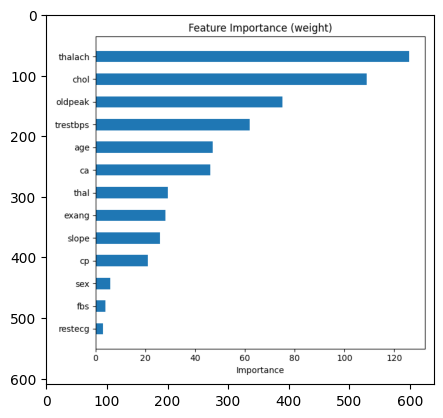

In [24]:
import matplotlib.pyplot as plt
import matplotlib.image as img

image = img.imread(file_path)
plt.imshow(image)
plt.show()

## Loading the model back

`autolog` has also logged the model for us, let's try to get it back

In [25]:
classifier = mlflow.xgboost.load_model(f"runs:/{run.info.run_id}/model")

See that the type returned by this method is an XGBoost model's classifier

In [26]:
type(classifier)

xgboost.sklearn.XGBClassifier

You can get prediction back from the model

In [27]:
classifier.predict(X_test)

array([0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1])

## Logging models with preprocessing

As can be seen, MLflow automatically logs models for you, but some times you need to log a different model, specially when you are doing preprocessing. In this example we did some categorical encoding, so our model right now expects the values of the column `thal` to be integers, not strings.

To make that requirement go away, we can create a Pipeline object with Scikit-Learn and log that model instead of the one automatically logged for us. Let's see how:

In [28]:
# Reload the dataset
df = pd.read_csv(file_url)

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.drop("target", axis=1), df["target"], test_size=0.3
)

### Using an encoder

First let's use a `OrdinalEncoder` instead of the categorical types

In [30]:
import numpy as np
from sklearn.preprocessing import OrdinalEncoder

We only need to transform the column `thal`. A convenient way to do this is by applying a `ColumnTransformer` to that column, the remaining columns will be sent directly to the model:

In [31]:
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier

encoder = ColumnTransformer(
    [
        (
            "cat_encoding",
            OrdinalEncoder(
                categories="auto",
                encoded_missing_value=np.nan,
            ),
            ["thal"],
        )
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
)

model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [33]:
pipeline = Pipeline(steps=[("encoding", encoder), ("model", model)])

In [34]:
pipeline

Pipeline(steps=[('encoding',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_encoding',
                                                  OrdinalEncoder(), ['thal'])],
                                   verbose_feature_names_out=False)),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categori...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

We can log this model in our run. Since this is a Scikit-Learn object, we will log it using such flavor instead of `xgboost`. Let's create a new complete run so we can see the difference.

### Signatures

One extra thing we need to take care of is the expected signature of the model. Signatures are use by MLflow to know what type of inputs are expected for a given model. This allows the model builder to be explicit about which types are being expected. In the first model we logged, all inputs needed to be numeric, including the column `thal`. However, our new pipeline can encode this values automatically so we can take `thal` values in string format.

In [35]:
from mlflow.models import infer_signature

signature = infer_signature(X_test, y_test)

Let's see the signature

In [36]:
signature

inputs: 
  ['age': long (required), 'sex': long (required), 'cp': long (required), 'trestbps': long (required), 'chol': long (required), 'fbs': long (required), 'restecg': long (required), 'thalach': long (required), 'exang': long (required), 'oldpeak': double (required), 'slope': long (required), 'ca': long (required), 'thal': string (required)]
outputs: 
  ['target': long (required)]
params: 
  None

### Logging the pipeline model

Now, it's time to to fit our entire pipeline and log it inside the run.

In [37]:
with mlflow.start_run() as run:
    pipeline.fit(X_train, y_train)
    mlflow.sklearn.log_model(pipeline, artifact_path="pipeline", signature=signature)

> **Note:** You are not required to log the pipeline model manually as you can also turn `mlflow.sklearn.autolog()` on. If you do that, the model will automatically be logged for for by Scikit-Learn integration with MLflow. However, we have preferred to it in this way to show the different approaches and to be explit about logging a pipeline.

If we explore try to get this model back now:

In [38]:
pipeline_model = mlflow.sklearn.load_model(f"runs:/{run.info.run_id}/pipeline")

Let's check the type of what's returned

In [39]:
type(pipeline_model)

sklearn.pipeline.Pipeline

Let's see how we can submit data in with categorical columns:

In [41]:
pipeline_model.predict(X_test)

ValueError: Found unknown categories ['2'] in column 0 during transform